# Software Image Generation
This notebook demonstrates generating a test image in software and displaying it on a HDMI device

First, some modules are loaded and the Pynq is configured:

In [4]:
%load_ext cython
import cython
from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("base.bit")
hdmi_out = base.video.hdmi_out

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


We'll define a function to generate a test image. A NumPy iterator is used to loop over every byte in an image array `f`. Each pixel element (red, green, blue) is accessed separately and written with an 8-bit intensity. First a colour (hue) index h is calculated by summing:

- The pixel coordinates, accessed with it.multi_index[0] and it.multi_index[1]
- The colour of the element it.multi_index[2] multiplied by 85, so that the red, green and blue peaks are offset by 1/3 of the repeating pattern
- The frame number `n` multiplied by 32, so that the pattern shifts on every frame

The result is truncated to an 8-bit number with a modulo operation, which causes a repeating cycle of colours.

A piecewise conversion function is used to convert the hue to an intensity. Values of 85 and below result in a linear ramp up of intensity, values 86 to 171 ramp down in intensity and values above 171 are set to 0.

In [24]:
def genImage(f, n):
  with np.nditer(f, flags=['multi_index'], op_flags=['writeonly']) as it:
    for x in it:
        h = (it.multi_index[0]+it.multi_index[1]+it.multi_index[2]*85+n) % 256
        if h <= 85:
            x[...] = h*3
        elif h <= 171:
            x[...] = (171-h)*3
        else:
            x[...] = 0

We can test it in the notebook using PIL:

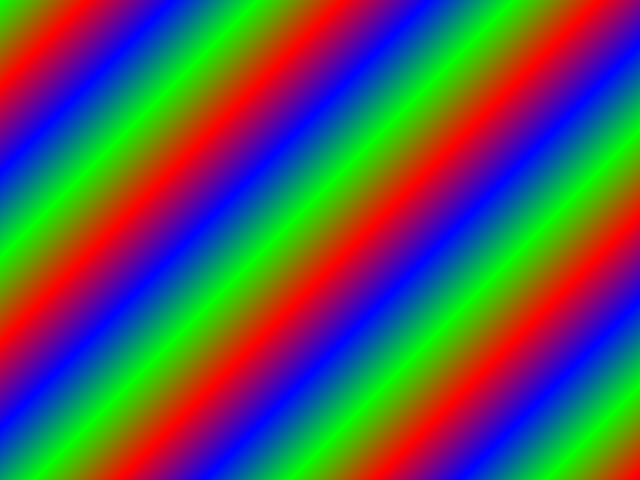

In [25]:
import PIL.Image
import numpy

frame = numpy.zeros((480,640,3), dtype = 'uint8')
genImage(frame,0)
image = PIL.Image.fromarray(frame)
image                    

The image can be displayed on the HDMI output. First, the HDMI output logic is initialised:

In [5]:
videoMode = common.VideoMode(640, 480, 24)
hdmi_out.configure(videoMode)
hdmi_out.cacheable_frames = False

hdmi_out.start()

Now we can generate a sequence of frames and display them. Each time, a reference to a new array in memory is created with `hdmi_out.newframe()`. Unlike normal Python objects, the library ensures that this array is accessible to the hardware. Changing the `n` parameter shifts the image in each frame.

In [27]:
from time import process_time
FRAMES = 5
FRAME_STEP = 32
start = process_time()

for n in range (FRAMES):
  f = hdmi_out.newframe()

  genImage(f,n*32)
    
  hdmi_out.writeframe(f)
  print('.', end='')
    
print("\n{:.2f} Frames per second".format(FRAMES/(process_time()-start)))  

.....
0.08 Frames per second


Notice how slow this example is, just to generate a simple test pattern. An interpreted language like Python is not a good choice for implmenting tight loops like pixel generation, particularly on the Pynq CPU core.

We can get a large speedup by compiling the image generation kernel into a C-like object. Cython offers a good trade-off between productivity and performance.

The cell below defines a new image generator function that will be compiled with Cython. Jupyter performs the compilation when the cell is executed.
The function is valid Python code, but all the variables have been annotated with types and the input array is defined as a three-dimensional array of `chars` (bytes) with `cython.char[:, :, :]`. The image generation kernel is the same as above, except that the array is indexed directly with one nested loop per dimension, instead of using the NumPy iterator. The cell takes a while to run due to the compilation, but this only needs to happen when the code in the function is changed

In [6]:
%%cython

def genImage_c(arr: cython.char[:, :, :], n: cython.int):
    y_max: Py_ssize_t  = arr.shape[0]
    x_max: Py_ssize_t  = arr.shape[1]
    c_max: Py_ssize_t  = arr.shape[2]
    
    x: Py_ssize_t
    y: Py_ssize_t
    c: Py_ssize_t
        
    for x in range(x_max):
      for y in range(y_max):
        for c in range(c_max):
            h = (x+y+c*85+n) % 256
            if h <= 85:
                arr[y,x,c] = h*3
            elif h <= 171:
                arr[y,x,c] = (171-h)*3
            else:
                arr[y,x,c] = 0

TypeError: dist must be a Distribution instance

In [51]:
FRAME_STEP = 2
FRAMES = 50

start = process_time()
for n in range (FRAMES):
  f = hdmi_out.newframe()
  genImage_c(f,n*FRAME_STEP)
  hdmi_out.writeframe(f)
  print('.', end='')
print("\n{:.2f} Frames per second".format(FRAMES/(process_time()-start)))

....................................................................................................
2.16 Frames per second


That's much faster, but it's not quick enough to produce a smooth animation and this is still a really simple example. So we'll need to generate images in hardware.

We need to stop the HDMI output to tidy up:

In [21]:
hdmi_out.close()